# Local SVR

This is Python code to fit SVR models on our time series data, and predict ahead!

What we will do:
1. Window our data into input and output windows
2. Run a supervised model (SVR/RF/GradientBoost)
3. Try using a "local" kernel, with inputs using seasonality
4. Fine tune the model

## 1) First, we are getting our data and environment set up

In [1]:
print('hello and welcome to a functioning script')

hello and welcome to a functioning script


In [2]:
import sys
print (sys.version)

3.8.8 (default, Feb 24 2021, 21:46:12) 
[GCC 7.3.0]


In [2]:
print('running')
import time
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit 
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
%matplotlib inline

os.chdir('/rds/general/user/ag1620/home/summerproj/results_data')
os.getcwd()

running


'/rds/general/user/ag1620/home/summerproj/results_data'

In [72]:
dataset_path = "lags_super_short_windowed6.csv"
df = pd.read_csv(dataset_path,header=0,index_col=0)

df['chunk'] =  pd.to_datetime(df['chunk'], format="%Y-%m-%d %H:%M:%S")
print(df.columns)
print(df.shape)

trainlength = df[df['traintest'].isin(range(0,1))].shape[0]
testlength = df[df['traintest'].isin(range(1,2))].shape[0]

print("Updated DataFrame:")
df.head()

Index(['chunk', 'in_texts_07', 'in_texts_08', 'in_texts_09', 'in_texts_10',
       'in_texts_11', 'in_texts_12', 'in_texts_13', 'in_texts_14',
       'in_lag1_texts_23', 'in_lag1_texts_00', 'in_lag2_texts_23',
       'in_lag2_texts_00', 'in_lag3_texts_23', 'in_lag3_texts_00',
       'in_lag4_texts_23', 'in_lag4_texts_00', 'in_temp_07', 'in_temp_08',
       'in_temp_09', 'in_temp_10', 'in_temp_11', 'in_temp_12', 'in_temp_13',
       'in_temp_14', 'in_tweet_avg_07', 'in_tweet_avg_08', 'in_tweet_avg_09',
       'in_tweet_avg_10', 'in_tweet_avg_11', 'in_tweet_avg_12',
       'in_tweet_avg_13', 'in_tweet_avg_14', 'in_retweet_avg_07',
       'in_retweet_avg_08', 'in_retweet_avg_09', 'in_retweet_avg_10',
       'in_retweet_avg_11', 'in_retweet_avg_12', 'in_retweet_avg_13',
       'in_retweet_avg_14', 'in_likes_avg_07', 'in_likes_avg_08',
       'in_likes_avg_09', 'in_likes_avg_10', 'in_likes_avg_11',
       'in_likes_avg_12', 'in_likes_avg_13', 'in_likes_avg_14', 'in_weekday',
       'in_clou

,chunk,in_texts_07,in_texts_08,in_texts_09,in_texts_10,in_texts_11,in_texts_12,in_texts_13,in_texts_14,in_lag1_texts_23,...,out_18,out_19,out_20,out_21,out_22,out_23,out_00,out_01,out_02,traintest
1,2021-03-28 14:00:00,2.236068,3.741657,4.242641,5.830952,5.916080,5.477226,6.480741,7.000000,10.049876,...,7.549834,8.306624,9.380832,10.344080,11.532563,10.198039,9.591663,8.660254,7.681146,0
2,2021-03-29 14:00:00,4.358899,4.582576,5.385165,5.385165,6.324555,5.916080,5.830952,6.324555,10.198039,...,7.483315,7.810250,9.055385,10.344080,10.954451,11.224972,10.099505,8.426150,6.480741,0
3,2021-03-30 14:00:00,3.464102,4.898979,5.385165,5.916080,4.690416,4.795832,5.567764,5.916080,11.224972,...,6.855655,7.141428,8.888194,11.000000,10.908712,10.246951,9.746794,6.928203,6.244998,0
4,2021-03-31 14:00:00,3.741657,4.242641,4.795832,5.477226,5.656854,6.324555,6.082763,6.480741,10.246951,...,7.000000,8.306624,8.485281,9.899495,10.862780,10.954451,9.110434,7.615773,6.082763,0
5,2021-04-01 14:00:00,3.464102,3.162278,4.898979,5.196152,5.099020,6.000000,6.000000,6.244998,10.954451,...,6.244998,7.483315,9.165151,8.888194,10.049876,10.049876,9.695360,9.273618,6.000000,0


In [73]:
# Splitting data into 
    # train
    # test

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train = df[:int(trainlength)]
test = df[trainlength:]

num_features = df.shape[1]

In [74]:
## Split Truth and Predictors for train
y_train = train[['out_15', 'out_16',
       'out_17', 'out_18', 'out_19', 'out_20', 'out_21', 'out_22', 'out_23',
       'out_00', 'out_01', 'out_02']]
print(y_train.shape)
X_train = train[['in_texts_07', 'in_texts_08', 'in_texts_09', 'in_texts_10',
       'in_texts_11', 'in_texts_12', 'in_texts_13', 'in_texts_14',
       'in_lag1_texts_23', 'in_lag1_texts_00', 'in_lag2_texts_23',
       'in_lag2_texts_00', 'in_lag3_texts_23', 'in_lag3_texts_00',
       'in_lag4_texts_23', 'in_lag4_texts_00', 'in_temp_07', 'in_temp_08',
       'in_temp_09', 'in_temp_10', 'in_temp_11', 'in_temp_12', 'in_temp_13',
       'in_temp_14', 'in_tweet_avg_07', 'in_tweet_avg_08', 'in_tweet_avg_09',
       'in_tweet_avg_10', 'in_tweet_avg_11', 'in_tweet_avg_12',
       'in_tweet_avg_13', 'in_tweet_avg_14', 'in_retweet_avg_07',
       'in_retweet_avg_08', 'in_retweet_avg_09', 'in_retweet_avg_10',
       'in_retweet_avg_11', 'in_retweet_avg_12', 'in_retweet_avg_13',
       'in_retweet_avg_14', 'in_likes_avg_07', 'in_likes_avg_08',
       'in_likes_avg_09', 'in_likes_avg_10', 'in_likes_avg_11',
       'in_likes_avg_12', 'in_likes_avg_13', 'in_likes_avg_14', 'in_weekday',
       'in_clouds', 'in_covid_deaths', 'in_covid_announcements'
                ]] #
print(X_train.shape)
y_test = test[['out_15', 'out_16',
       'out_17', 'out_18', 'out_19', 'out_20', 'out_21', 'out_22', 'out_23',
       'out_00', 'out_01', 'out_02']]
print(y_test.shape)
X_test = test[['in_texts_07', 'in_texts_08', 'in_texts_09', 'in_texts_10',
       'in_texts_11', 'in_texts_12', 'in_texts_13', 'in_texts_14',
       'in_lag1_texts_23', 'in_lag1_texts_00', 'in_lag2_texts_23',
       'in_lag2_texts_00', 'in_lag3_texts_23', 'in_lag3_texts_00',
       'in_lag4_texts_23', 'in_lag4_texts_00', 'in_temp_07', 'in_temp_08',
       'in_temp_09', 'in_temp_10', 'in_temp_11', 'in_temp_12', 'in_temp_13',
       'in_temp_14', 'in_tweet_avg_07', 'in_tweet_avg_08', 'in_tweet_avg_09',
       'in_tweet_avg_10', 'in_tweet_avg_11', 'in_tweet_avg_12',
       'in_tweet_avg_13', 'in_tweet_avg_14', 'in_retweet_avg_07',
       'in_retweet_avg_08', 'in_retweet_avg_09', 'in_retweet_avg_10',
       'in_retweet_avg_11', 'in_retweet_avg_12', 'in_retweet_avg_13',
       'in_retweet_avg_14', 'in_likes_avg_07', 'in_likes_avg_08',
       'in_likes_avg_09', 'in_likes_avg_10', 'in_likes_avg_11',
       'in_likes_avg_12', 'in_likes_avg_13', 'in_likes_avg_14', 'in_weekday',
       'in_clouds', 'in_covid_deaths', 'in_covid_announcements'
                ]]  #
print(X_test.shape)

(15, 12)
(15, 52)
(1, 12)
(1, 52)


In [75]:
# Rescale the dataset
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
# Check data types
print("X_train:" + str(type(X_train)))
print(X_train.shape)
print("y_train:" + str(type(y_train)))
print(y_train.shape)
print("X_test:" + str(type(X_test)))
print(X_test.shape)
print("y_test:" + str(type(y_test)))
print(y_test.shape)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

X_train:<class 'numpy.ndarray'>
(15, 52)
y_train:<class 'pandas.core.frame.DataFrame'>
(15, 12)
X_test:<class 'numpy.ndarray'>
(1, 52)
y_test:<class 'pandas.core.frame.DataFrame'>
(1, 12)


In [76]:
X_train

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,50,51
0,-2.595581,-0.674294,-0.439761,0.857090,0.308176,-0.667753,0.387609,1.050811,-1.203136,0.271721,...,0.573267,-0.628149,0.923060,0.917044,0.772295,0.773739,0.000000,0.852196,0.719218,-0.267261
1,1.837186,0.781535,1.109834,0.176131,1.055089,0.088267,-1.025731,-0.559638,-0.901444,-0.083018,...,1.286471,1.025066,0.627203,0.768594,0.589563,0.580443,-1.035098,0.852196,0.719218,3.741657
2,-0.031276,1.329305,1.109834,0.987126,-1.932997,-1.841600,-1.598184,-1.533558,1.189606,0.790249,...,-1.570922,-1.182493,-1.227440,-1.238187,0.402401,0.390713,1.035098,-1.377386,1.970033,-0.267261
3,0.548300,0.193027,0.310527,0.316758,-0.165828,0.791954,-0.478024,-0.187248,-0.801850,0.183740,...,-0.255141,1.748504,1.559210,1.572693,1.597526,1.605880,1.552648,-1.377386,1.344626,-0.267261
4,-0.031276,-1.677338,0.450425,-0.112593,-1.185850,0.232838,-0.658039,-0.749325,0.638769,-0.910523,...,-0.415717,-0.520974,-0.522717,-0.540543,-1.021894,-0.924637,0.517549,1.298112,0.250163,-0.267261
5,0.822527,-1.410127,-0.768853,-0.260968,1.892147,0.516076,1.517037,-1.136140,-1.203136,0.095295,...,1.485742,1.161069,0.943088,0.910537,0.811441,0.805365,-1.552648,-0.188276,-0.218893,-0.267261
6,0.822527,-1.154809,-0.128499,0.033058,-0.662622,-0.207208,-0.658039,-0.187248,0.915867,-1.884536,...,-1.218876,-0.897725,0.028105,0.004745,-0.350681,-0.372700,-0.517549,1.298112,0.250163,-0.267261
7,0.264091,0.781535,0.450425,-0.412225,-0.833887,-2.208979,-0.478024,0.706651,-0.408137,0.704908,...,0.224497,0.153532,-0.031908,-0.844979,-0.747137,-0.706902,0.000000,-1.377386,-0.687948,-0.267261
8,-0.031276,-0.446938,1.357492,-0.112593,0.762265,1.452871,-0.658039,0.531825,0.169126,0.271721,...,0.573267,0.396255,0.233122,0.430913,0.188006,0.173377,-1.035098,-1.377386,-1.938763,-0.267261
9,-0.661526,-0.446938,1.109834,-1.939767,-0.165828,-0.826347,1.203075,1.554139,-0.213990,0.446319,...,1.062800,1.173490,0.969081,1.186591,1.590295,1.598575,1.035098,-0.188276,-0.218893,-0.267261


## 3) Fitting Models

In [8]:
## Fit regression model
#svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
#svr_lin = SVR(kernel='linear', C=100, gamma='auto')
#svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1, coef0=1)

In [283]:
# Cross Validation # Default 5-fold cross validation
parameters = {'base_estimator__kernel': ['rbf'], # ,'linear','poly'
              'base_estimator__C': [0.001, 0.01, 0.1, 1], # range(80,120,20), # Lower = More regularisation
              'base_estimator__gamma': [0.000001, 0.00001, 0.0001], # 'scale','auto' # Lower = samples have larger radius of influence - "smoothness of the forecasting function"
              'base_estimator__epsilon': [0.001, 0.01, 0.1] } # 
gscv = GridSearchCV(RegressorChain(SVR()), parameters, n_jobs=1) # scoring='neg_median_absolute_error' > this makes the predictions far worse

In [328]:
# Cross Validation # Default 5-fold cross validation
params = {'n_estimators': [100,500],
          'max_depth': [2,4],
          'min_samples_split': [5,10]
         } # 
gscv = GridSearchCV(RandomForestRegressor(), params, n_jobs=1)

In [333]:
# Cross Validation # Default 5-fold cross validation
params = {'estimator__n_estimators': [500],
          'estimator__max_depth': [4],
          'estimator__min_samples_split': [5],
          'estimator__learning_rate': [0.01],
          'estimator__loss': ['ls']
         } # 
gscv = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor()), params, n_jobs=1)

In [160]:
# Cross Validation # Default 5-fold cross validation
params = {'max_iter': [10000],
          'activation': ['relu']
         } # 
gscv = GridSearchCV(MLPRegressor(), params, n_jobs=1)

In [116]:
MLPRegressor().get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [87]:
MultiOutputRegressor(RandomForestRegressor()).get_params()

{'estimator__bootstrap': True,
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'mse',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__max_samples': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estimator__n_jobs': None,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'estimator': RandomForestRegressor(),
 'n_jobs': None}

In [77]:
# Cross Validation # Default 5-fold cross validation
parameters = {'estimator__kernel': ['rbf'], # ,'linear','poly'
              'estimator__C': [0.001, 0.01, 0.1, 1], # range(80,120,20), # Lower = More regularisation
              'estimator__gamma': [0.000001, 0.00001, 0.0001], # 'scale','auto' # Lower = samples have larger radius of influence - "smoothness of the forecasting function"
              'estimator__epsilon': [0.001, 0.01, 0.1] } # 
gscv = GridSearchCV(MultiOutputRegressor(SVR()), parameters, n_jobs=1) # scoring='neg_median_absolute_error' > this makes the predictions far worse

In [78]:
print('running')
#import time
t0 = time.time()

gscv.fit(X=X_train, y=y_train)
print(gscv.best_params_)
svr_model = gscv.best_estimator_

t1 = time.time()
total = t1-t0
print(total)

running
{'estimator__C': 1, 'estimator__epsilon': 0.01, 'estimator__gamma': 0.0001, 'estimator__kernel': 'rbf'}
4.0158140659332275


In [79]:
#import time
t0 = time.time()

y_pred = svr_model.predict(X_test[:12]) ** 2
y_test = y_test[:12]
t1 = time.time()
total = t1-t0
print(total)

y_pred = pd.DataFrame(y_pred, columns = y_test.columns)
preds = pd.concat([y_pred.T,y_test.T** 2], axis=1)
preds.columns = ['Preds','Truth']
preds

0.007007598876953125


,Preds,Truth
out_15,42.102245,36.0
out_16,48.706599,31.0
out_17,50.804132,36.0
out_18,52.058519,41.0
out_19,63.058042,57.0
out_20,88.107100,99.0
out_21,93.984843,103.0
out_22,109.866994,99.0
out_23,114.766621,121.0
out_00,94.395287,240.0


## 4) Assessing Performance

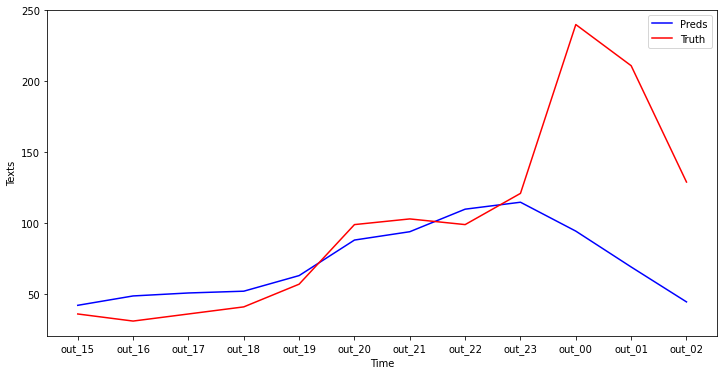

In [80]:
p= preds['Preds']
t= preds['Truth']
fig = plt.figure(figsize=(12,6))
plt.plot(preds['Preds'],color='b',label='Preds')
plt.plot(preds['Truth'],color='r',label='Truth')
plt.xlabel("Time")
plt.ylabel("Texts")
plt.legend()
plt.show()

In [81]:
# ASSESS ERROR METRICS
import math
# Get error metrics
MAE = metrics.mean_absolute_error(t, p)
MSE = metrics.mean_squared_error(t, p)
RMSE = math.sqrt(MSE)
R2 = metrics.r2_score(t, p)
maxerror = metrics.max_error(t, p)
peakperc = 100*max(p)/max(t)
print(' MAE = {}\n MSE = {}\n RMSE = {}\n R2= {}\n max-error = {}\n peak-perc = {}'.format(MAE, MSE, RMSE, R2, maxerror, peakperc))

 MAE = 38.72473509328035
 MSE = 4129.280763988571
 RMSE = 64.25947995423377
 R2= 0.03776742640749653
 max-error = 145.60471331265944
 peak-perc = 47.81942531727998


In [59]:
# training performance
y_trainpred = svr_model.predict(X_train) ** 2
y_traintruth = y_train ** 2
MAE = metrics.mean_absolute_error(y_traintruth, y_trainpred)
MSE = metrics.mean_squared_error(y_traintruth, y_trainpred)
RMSE = math.sqrt(MSE)
R2 = metrics.r2_score(y_traintruth, y_trainpred)
#maxerror = metrics.max_error(y_traintruth, y_trainpred)
print(' MAE = {}\n MSE = {}\n RMSE = {}\n R2= {}\n max-error = {}'.format(MAE, MSE, RMSE, R2, maxerror))

 MAE = 20.662682961764688
 MSE = 1538.1260953348146
 RMSE = 39.21895071690234
 R2= -0.037882512858593814
 max-error = 226.75634702560592


## 5) Save Predictions

In [82]:
# save test set performance dataframe
preds.to_csv('super_short_lag_6_Local_SVR_preds.csv')

In [37]:
# save training set performance dataframe
#trainchunk = pd.DataFrame(train['chunk']).reset_index(drop=True)
ytrain = pd.DataFrame(y_traintruth).reset_index(drop=True)
ytrainpred = pd.DataFrame(y_trainpred).reset_index(drop=True)
df_c = pd.concat([trainchunk,ytrain,ytrainpred], axis=1)
#df_c.columns = ['truth','preds']
df_c.head()

,chunk,out_15,out_16,out_17,out_18,out_19,out_20,out_21,out_22,out_23,...,2,3,4,5,6,7,8,9,10,11
0,2021-01-19 15:00:00,125.0,63.0,72.0,68.0,77.0,91.0,108.0,126.0,103.0,...,63.475386,66.499060,76.017442,90.999999,91.499319,116.499468,114.999998,100.494405,83.000005,59.995835
1,2021-01-20 15:00:00,44.0,45.0,66.0,64.0,84.0,84.0,92.0,121.0,123.0,...,63.475386,66.499057,76.017442,90.999998,91.499319,116.499469,115.000000,100.494402,83.000005,59.995835
2,2021-01-21 15:00:00,44.0,46.0,59.0,66.0,63.0,75.0,86.0,129.0,117.0,...,63.475385,66.499061,76.017436,91.000000,91.499318,116.499465,114.999999,100.494403,83.000000,59.995834
3,2021-01-22 15:00:00,45.0,36.0,45.0,50.0,69.0,92.0,83.0,113.0,111.0,...,63.475384,66.499060,76.017436,91.000003,91.499318,116.499463,114.999997,100.494399,82.999998,59.995832
4,2021-01-23 15:00:00,35.0,57.0,70.0,70.0,73.0,68.0,91.0,112.0,110.0,...,63.475386,66.499064,76.017435,91.000001,91.499318,116.499461,114.999999,100.494402,82.999999,59.995836
